# Run a sktime model on Amazon SageMaker (Script Mode) 

In [1]:
# install/upgrade needed package
# please restart the notebook after the installation finished
!pip install -q sktime
!pip install -q -U sagemaker

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [5]:
import sagemaker

session = sagemaker.Session()
bucket = session.default_bucket()

## Prepare our dataset

In [6]:
import pandas as pd
import numpy as np
from sktime.datasets import load_airline

airline_dataset = load_airline()
airline_dataset

Period
1949-01    112.0
1949-02    118.0
1949-03    132.0
1949-04    129.0
1949-05    121.0
           ...  
1960-08    606.0
1960-09    508.0
1960-10    461.0
1960-11    390.0
1960-12    432.0
Freq: M, Name: Number of airline passengers, Length: 144, dtype: float64

In [7]:
airline_dataset.to_csv('airline.csv')

## Upload dataset to S3 bucket so it can be passed to our Training Job

In [8]:
prefix = 'sklearn-sktime-airline'

training = session.upload_data(path='airline.csv', key_prefix=prefix + "/training")
output   = 's3://{}/{}/output/'.format(bucket, prefix)
print(training)
print(output)

s3://sagemaker-ali-playground/sklearn-sktime-airline/training/airline.csv
s3://sagemaker-ali-playground/sklearn-sktime-airline/output/


## Defining SageMaker Training Job

In [10]:
from sagemaker.sklearn import SKLearn

sk_model = SKLearn(entry_point='sktime_sagemaker.py',
             role=sagemaker.get_execution_role(),
             framework_version='0.23-1',
             instance_count=1, 
             instance_type='ml.m5.large',
             output_path=output,
             base_job_name='sktime-test-model')

sk_model.fit({'training':training})

2021-08-11 17:04:25 Starting - Starting the training job...
2021-08-11 17:04:47 Starting - Launching requested ML instancesProfilerReport-1628701465: InProgress
......
2021-08-11 17:05:48 Starting - Preparing the instances for training......
2021-08-11 17:06:54 Downloading - Downloading input data...
2021-08-11 17:07:14 Training - Downloading the training image..2021-08-11 17:07:38,180 sagemaker-containers INFO     Imported framework sagemaker_sklearn_container.training
2021-08-11 17:07:38,182 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2021-08-11 17:07:38,191 sagemaker_sklearn_container.training INFO     Invoking user training script.
2021-08-11 17:07:38,455 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2021-08-11 17:07:39,076 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2021-08-11 17:07:39,088 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus install

## Creat a Real-Time inference Endpoint for our trained model

In [13]:
sk_predictor = sk_model.deploy(endpoint_name='sktime-naiveforcaster', initial_instance_count=1, instance_type='ml.m5.large')

# set the predictor input/output configurations
sk_predictor.serializer = sagemaker.serializers.CSVSerializer()
sk_predictor.deserializer = sagemaker.deserializers.NumpyDeserializer()

----------------!

## See our model prediction!

0.145427686270316

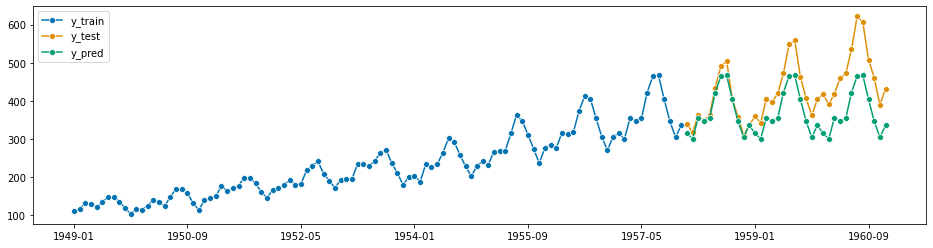

In [15]:
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sktime.forecasting.naive import NaiveForecaster
from sktime.utils.plotting import plot_series


y_train, y_test = temporal_train_test_split(dataset, test_size=36)

fh = np.arange(1, len(y_test) + 1)

y_pred = pd.Series(sk_predictor.predict(fh), index=y_test.index)

plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_pred, y_test)

In [16]:
# make sure to delete the endpoint after you finished
sk_predictor.delete_endpoint()